## BERT Glue E2E

https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu

In [1]:
# You will use a separate model to preprocess text before using it to fine-tune BERT. 
# This model depends on tensorflow/text, which you will install below.
% pip install -q -U tensorflow-text

In [2]:
# You will use the AdamW optimizer from tensorflow/models to fine-tune BERT, which you will install as well.
% pip install -q -U tf-models-official

In [3]:
% pip install -U tfds-nightly

Requirement already up-to-date: tfds-nightly in /usr/local/lib/python3.6/dist-packages (4.2.0.dev202102150106)


In [4]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [5]:
# The TPU can only read directly from Cloud Storage buckets.
# The following setting is automatic in Colab
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

**Connect to the TPU worker**

The following code connects to the TPU worker and changes TensorFlow's default device to the CPU device on the TPU worker. It also defines a TPU distribution strategy that you will use to distribute model training onto the 8 separate TPU cores available on this one TPU worker. See TensorFlow's TPU guide for more information.

In [6]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')
elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recomended.')

Using TPU


Choose a BERT model to fine-tune

In [7]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 
bert_model_name = 'bert_en_wwm_uncased_L-24_H-1024_A-16'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocessing model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Preprocess the Text

On the Classify text with BERT colab the preprocessing model is used directly embedded with the BERT encoder.

This tutorial demonstrates how to do preprocessing as part of your input pipeline for training, using Dataset.map, and then merge it into the model that gets exported for inference. That way, both training and inference can work from raw text inputs, although the TPU itself requires numeric inputs.

TPU requirements aside, it can help performance have preprocessing done asynchronously in an input pipeline (you can learn more in the tf.data performance guide).

This tutorial also demonstrates how to build multi-input models, and how to adjust the sequence length of the inputs to BERT.

Let's demonstrate the preprocessing model.

In [8]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


Each preprocessing model also provides a method,.bert_pack_inputs(tensors, seq_length), which takes a list of tokens (like tok above) and a sequence length argument. This packs the inputs to create a dictionary of tensors in the format expected by the BERT model.

In [9]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


Here are some details to pay attention to:

input_mask The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.
input_type_ids has the same shape of input_mask, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of.
Next, you will create a preprocessing model that encapsulates all this logic. Your model will take strings as input, and return appropriately formatted objects which can be passed to BERT.

Each BERT model has a specific preprocessing model, make sure to use the proper one described on the BERT's model documentation

In [10]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

Let's demonstrate the preprocessing model. You will create a test with two sentences input (input1 and input2). The output is what a BERT model would expect as input: input_word_ids, input_masks and input_type_ids.

In [11]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


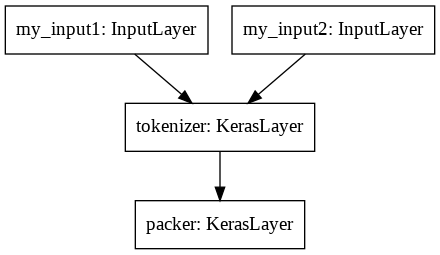

In [12]:
tf.keras.utils.plot_model(test_preprocess_model)

In [13]:
# To apply the preprocessing in all the inputs from the dataset, you will use the map function from the dataset. 
# The result is then cached for performance.

AUTOTUNE = tf.data.AUTOTUNE

def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  return dataset, num_examples

Define your model

You are now ready to define your model for sentence or sentence pair classification by feeding the preprocessed inputs through the BERT encoder and putting a linear classifier on top (or other arrangement of layers as you prefer), and using dropout for regularization.

In [14]:
def build_classifier_model(num_classes):
  inputs = dict(
      input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
  )

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='encoder')
  net = encoder(inputs)['pooled_output']
  net = tf.keras.layers.Dropout(rate=0.1)(net)
  net = tf.keras.layers.Dense(num_classes, activation=None, name='classifier')(net)
  return tf.keras.Model(inputs, net, name='prediction')

In [15]:
# Let's try running the model on some preprocessed inputs.

test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.11534873 0.85651255]], shape=(1, 2), dtype=float32)


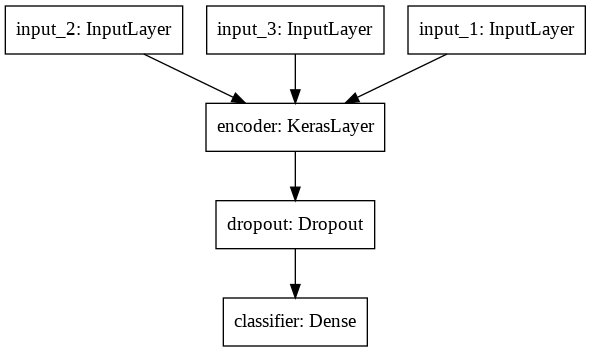

In [16]:
# Let's take a look at the model's structure. You can see the three BERT expected inputs.
tf.keras.utils.plot_model(test_classifier_model)

Choose a task from GLUE
You are going to use a TensorFlow DataSet from the GLUE benchmark suite.

Colab lets you download these small datasets to the local filesystem, and the code below reads them entirely into memory, because the separate TPU worker host cannot access the local filesystem of the colab runtime.

For bigger datasets, you'll need to create your own Google Cloud Storage bucket and have the TPU worker read the data from there. You can learn more in the TPU guide.

It's recommended to start with the CoLa dataset (for single sentence) or MRPC (for multi sentence) since these are small and don't take long to fine tune.

In [17]:
tfds_name = 'glue/cola' 
# tfds_name = 'glue/sst2' 
# tfds_name = 'glue/qnli'

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)



In [18]:
# The dataset also determines the problem type (classification or regression) and the appropriate loss function for training.
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  if glue_task is 'glue/cola':
    metrics = tfa.metrics.MatthewsCorrelationCoefficient()
  else:
    metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metrics, loss

**Train your model**

Finally, you can train the model end-to-end on the dataset you chose.

**Distribution**

Recall the set-up code at the top, which has connected the colab runtime to a TPU worker with multiple TPU devices. To distribute training onto them, you will create and compile your main Keras model within the scope of the TPU distribution strategy. (For details, see Distributed training with Keras.)

Preprocessing, on the other hand, runs on the CPU of the worker host, not the TPUs, so the Keras model for preprocessing as well as the training and validation datasets mapped with it are built outside the distribution strategy scope. The call to Model.fit() will take care of distributing the passed-in dataset to the model replicas.

Note: The single TPU worker host already has the resource objects (think: a lookup table) needed for tokenization. Scaling up to multiple workers requires use of Strategy.experimental_distribute_datasets_from_function with a function that loads the preprocessing model separately onto each worker.

**Optimizer**

Fine-tuning follows the optimizer set-up from BERT pre-training (as in Classify text with BERT): It uses the AdamW optimizer with a linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [19]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model for {tfds_name}')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

with strategy.scope():

  # metric have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Fine tuning https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3 model for glue/cola


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 1/3


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


267/267 [==============================] - 184s 226ms/step - loss: 0.6003 - accuracy: 0.7093 - val_loss: 0.5115 - val_accuracy: 0.8379
Epoch 2/3
267/267 [==============================] - 51s 192ms/step - loss: 0.3190 - accuracy: 0.8933 - val_loss: 0.5538 - val_accuracy: 0.8486
Epoch 3/3
267/267 [==============================] - 51s 192ms/step - loss: 0.1628 - accuracy: 0.9530 - val_loss: 0.6790 - val_accuracy: 0.8496


In [20]:
# Results
# CoLA 82.4% validation accuracy for model bert_en_uncased_L-12_H-768_A-12
# 267/267 [==============================] - 21s 78ms/step - loss: 0.2550 - accuracy: 0.9114 - val_loss: 0.6072 - val_accuracy: 0.8242
# CoLA 84.9% validation accuracy for model bert_en_wwm_uncased_L-24_H-1024_A-16/3
267/267 [==============================] - 51s 192ms/step - loss: 0.1628 - accuracy: 0.9530 - val_loss: 0.6790 - val_accuracy: 0.8496

# SST-2 92.5% validation accuracy for model bert_en_uncased_L-12_H-768_A-12
# 2104/2104 [==============================] - 157s 75ms/step - loss: 0.0784 - accuracy: 0.9788 - val_loss: 0.3405 - val_accuracy: 0.9259
# SST-2 93.6% validation accuracy for model bert_en_wwm_uncased_L-24_H-1024_A-16/3
# 3273/3273 [==============================] - 624s 191ms/step - loss: 0.1069 - accuracy: 0.9731 - val_loss: 0.3246 - val_accuracy: 0.9331

# QNLI 91.6% validation accuracy for model bert_en_uncased_L-12_H-768_A-12
# 3273/3273 [==============================] - 252s 77ms/step - loss: 0.1556 - accuracy: 0.9546 - val_loss: 0.3349 - val_accuracy: 0.9158
# QNLI 93.8% validation accuracy for model bert_en_wwm_uncased_L-24_H-1024_A-16/3
# 3273/3273 [==============================] - 614s 188ms/step - loss: 0.0895 - accuracy: 0.9775 - val_loss: 0.3140 - val_accuracy: 0.9384


**Export for inference**

You will create a final model that has the preprocessing part and the fine-tuned BERT we've just created.

At inference time, preprocessing needs to be part of the model (because there is no longer a separate input queue as for training data that does it). Preprocessing is not just computation; it has its own resources (the vocab table) that must be attached to the Keras Model that is saved for export. This final assembly is what will be saved.

You are going to save the model on colab and later you can download to keep it for the future (View -> Table of contents -> Files).

In [21]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/", "_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print(f'Saving {saved_model_path}')

# Save everything on the Colab host (even the variables from TPU memory)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False, options=save_options)

Saving ./my_models/glue_cola_bert_en_wwm_uncased_L-24_H-1024_A-16


In [22]:
%ls my_models

glue_cola_bert_en_wwm_uncased_L-24_H-1024_A-16/
glue_qnli_bert_en_wwm_uncased_L-24_H-1024_A-16/
glue_sst2_bert_en_wwm_uncased_L-24_H-1024_A-16/


**Test the model**

The final step is testing the results of your exported model.

Just to make some comparison, let's reload the model and test it using some inputs from the test split from the dataset.

Note: The test is done on the colab host, not the TPU worker that it has connected to, so it appears below with explicit device placements. You can omit those when loading the SavedModel elsewhere.

In [23]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

In [24]:
def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs


def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs


def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  if dataset_name == 'glue/cola':
    print(f'sentence: {test[0].numpy()}')
    if bert_result_class == 1:
      print(f'This sentence is acceptable')
    else:
      print(f'This sentence is unacceptable')

  elif dataset_name == 'glue/sst2':
    print(f'sentence: {test[0]}')
    if bert_result_class == 1:
      print(f'This sentence has POSITIVE sentiment')
    else:
      print(f'This sentence has NEGATIVE sentiment')

  elif dataset_name == 'glue/mrpc':
    print(f'sentence1: {test[0]}')
    print(f'sentence2: {test[1]}')
    if bert_result_class == 1:
      print(f'Are a paraphrase')
    else:
      print(f'Are NOT a paraphrase')

  elif dataset_name == 'glue/qqp':
    print(f'question1: {test[0]}')
    print(f'question2: {test[1]}')
    if bert_result_class == 1:
      print(f'Questions are similar')
    else:
      print(f'Questions are NOT similar')

  elif dataset_name == 'glue/mnli':
    print(f'premise   : {test[0]}')
    print(f'hypothesis: {test[1]}')
    if bert_result_class == 1:
      print(f'This premise is NEUTRAL to the hypothesis')
    elif bert_result_class == 2:
      print(f'This premise CONTRADICTS the hypothesis')
    else:
      print(f'This premise ENTAILS the hypothesis')

  elif dataset_name == 'glue/qnli':
    print(f'question: {test[0]}')
    print(f'sentence: {test[1]}')
    if bert_result_class == 1:
      print(f'The question is NOT answerable by the sentence')
    else:
      print(f'The question is answerable by the sentence')

  elif dataset_name == 'glue/rte':
    print(f'sentence1: {test[0]}')
    print(f'sentence2: {test[1]}')
    if bert_result_class == 1:
      print(f'Sentence1 DOES NOT entails sentence2')
    else:
      print(f'Sentence1 entails sentence2')

  elif dataset_name == 'glue/wnli':
    print(f'sentence1: {test[0]}')
    print(f'sentence2: {test[1]}')
    if bert_result_class == 1:
      print(f'Sentence1 DOES NOT entails sentence2')
    else:
      print(f'Sentence1 entails sentence2')

  print(f'Bert raw results:{bert_result[0]}')
  print()

**Test**

In [25]:
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(5):
    if len(sentence_features) == 1:
      result = reloaded_model(test_row[0])
    else:
      result = reloaded_model(list(test_row))

    print_bert_results(test_row, result, tfds_name)

sentence: [b'That silly fool broke the teapot.']
This sentence is acceptable
Bert raw results:[-3.0747712  4.318989 ]

sentence: [b'Steve tossed Anna the ball.']
This sentence is acceptable
Bert raw results:[-2.2994602  3.3863993]

sentence: [b'The book was given by John to Mary.']
This sentence is acceptable
Bert raw results:[-2.9519103  4.103157 ]

sentence: [b'Kevin urged Anne to be loyal to herself.']
This sentence is acceptable
Bert raw results:[-3.7937217  4.264505 ]

sentence: [b"When we sell the house, we'll probably leave most of the furniture."]
This sentence is acceptable
Bert raw results:[-3.0671856  3.8671496]



In [26]:
test_dataset.element_spec

{'idx': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}

If you want to use your model on TF Serving, remember that it will call your SavedModel through one of its named signatures. Notice there are some small differences in the input. In Python, you can test them as follows:

In [27]:
with tf.device('/job:localhost'):
  serving_model = reloaded_model.signatures['serving_default']
  for test_row in test_dataset.shuffle(1000).map(prepare_serving).take(5):
    result = serving_model(**test_row)
    # The 'prediction' key is the classifier's defined model name.
    print_bert_results(list(test_row.values()), result['prediction'], tfds_name)

sentence: b'She thought it was likely that everyone would fit into the car.'
This sentence is acceptable
Bert raw results:[-2.668784   4.0301905]

sentence: b'John made a doll for his son.'
This sentence is acceptable
Bert raw results:[-3.8181999  4.2870173]

sentence: b'Sentences some go on and on.'
This sentence is unacceptable
Bert raw results:[ 1.2281017 -2.8270729]

sentence: b'She laughed in embarrassment.'
This sentence is acceptable
Bert raw results:[-3.237706  4.2011  ]

sentence: b'We persuaded there to be several students at the talk.'
This sentence is unacceptable
Bert raw results:[ 1.6691458 -2.952706 ]

